In [ ]:
# basics
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import random
from functools import partial
import networkx as nx
# penny
import pennylane as qml
from pennylane.transforms import compile, commutation_dag
from pennylane.math import fidelity_statevector as fidelity_penny
# qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Gate
from qiskit_aer import Aer, AerSimulator
from qiskit.visualization import plot_circuit_layout, circuit_drawer
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import state_fidelity as fidelity_qiskit
from math import pi
import copy
# graph
import networkx as nx

In [93]:
from transpilation_util import *

In [98]:
[ds] = qml.data.load("ketgpt")

In [9]:
random.seed(42)
# seed = random.randint(0,1000)
seed = 0

def summary_penny(circuit):
    obj = qml.specs(circuit)()['resources']
    summary =  [obj.num_wires, obj.num_gates, obj.gate_sizes[1], obj.gate_sizes[2], obj.depth]
    df = pd.DataFrame(summary, index=['num_qubit', 'num_gate', 'num_1q_gate', 'num_2q_gate', 'depth'])
    df = df.T
    print(df)

In [ ]:
@qml.qnode(qml.device('default.qubit'))
def circuit(): # 0 to 99
    for op in ds.circuits[seed]:
        qml.apply(op)
    return qml.state()

print(summary_penny(circuit))

   num_qubit  num_gate  num_1q_gate  num_2q_gate  depth
0         13       205          116           89     72
None


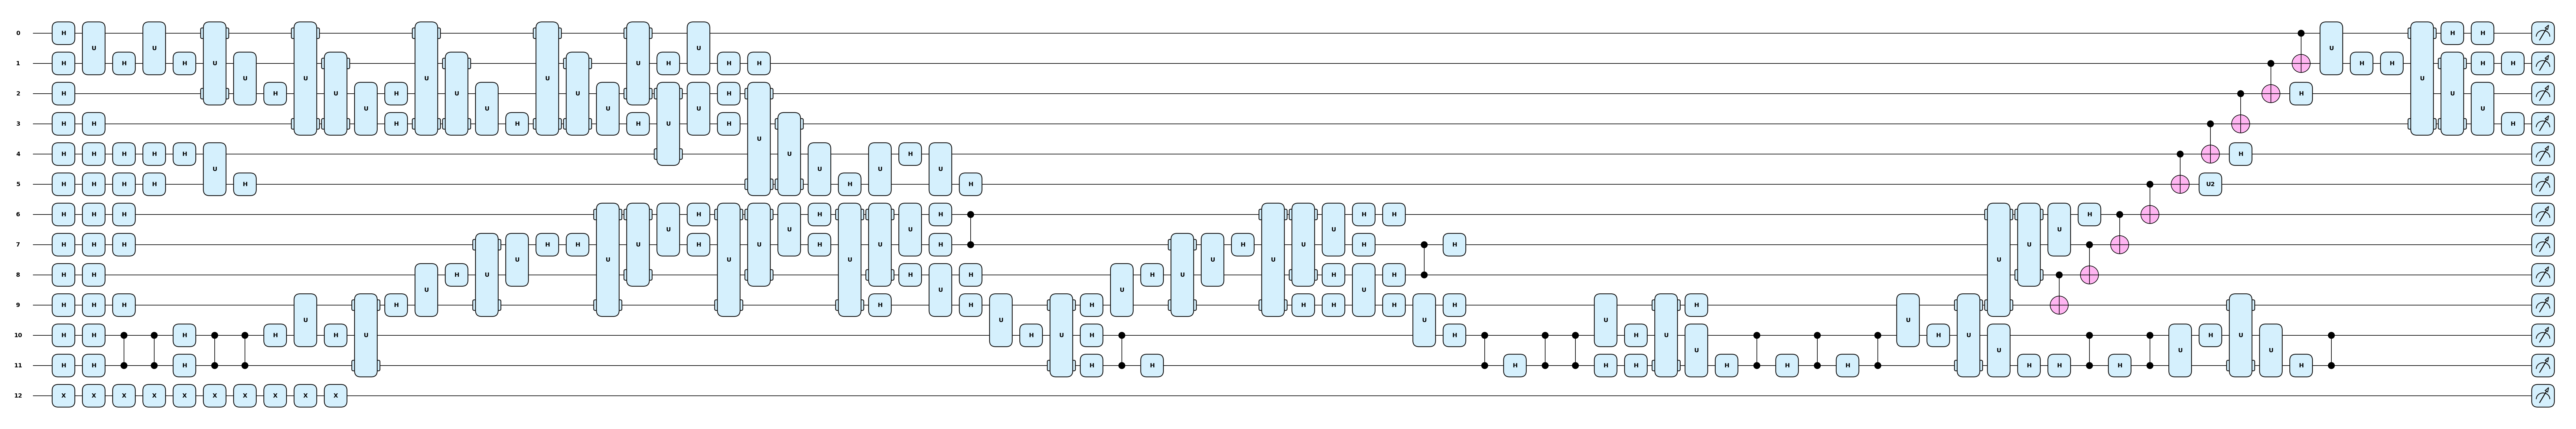

In [23]:
fig, axs = qml.draw_mpl(circuit, style='pennylane')()
plt.show()

In [11]:
circuit_info  = extract_info_from_qnode(circuit)
circuit_info[:5]

[{'name': 'Hadamard', 'wires': [0], 'params': []},
 {'name': 'Hadamard', 'wires': [1], 'params': []},
 {'name': 'Hadamard', 'wires': [2], 'params': []},
 {'name': 'Hadamard', 'wires': [3], 'params': []},
 {'name': 'Hadamard', 'wires': [4], 'params': []}]

In [ ]:
def circuit_to_graph(circuit_info):
    # Gate color map
    gate_colors = {
        'Hadamard': '#cc4c4c',
        'PauliX': '#cc9c4c',
        'CNOT': '#aacc4c',
        'CZ': '#4ccc5c',
        'RY': '#4ccccc',
        'QubitUnitary': '#4c6ccc',
        'U1': '#9c4ccc',
        'U2': '#cc4ca2'
    }

    measurement_color = '#808080'  
    qubit_color = '#808080'        

    G = nx.DiGraph()

    # Determine number of qubits
    num_qubits = max(w for gate in circuit_info for w in gate['wires']) + 1

    # Add qubit nodes
    for q in range(num_qubits):
        G.add_node(f"q[{q}]", type='qubit')

    # Track gate sequence per qubit
    qubit_timelines = {q: [] for q in range(num_qubits)}

    # Add gate nodes and build timeline
    for i, gate in enumerate(circuit_info):
        gate_id = f"{gate['name']}_{i}"
        G.add_node(gate_id, type='gate', label=gate['name'], params=gate['params'], wires=gate['wires'])

        for wire in gate['wires']:
            qubit_timelines[wire].append(gate_id)

    # Add edges: qubit → first gate, gate → next gate (per qubit)
    for q, timeline in qubit_timelines.items():
        if timeline:
            G.add_edge(f"q[{q}]", timeline[0])
            for i in range(len(timeline) - 1):
                G.add_edge(timeline[i], timeline[i + 1])

    # Layout: qubits on left, gates in time order
    pos = {}
    x_spacing = 0.6
    y_spacing = 0.8

    for q in range(num_qubits):
        pos[f"q[{q}]"] = (0, -q * y_spacing)

    for i, gate in enumerate(circuit_info):
        gate_id = f"{gate['name']}_{i}"
        avg_y = -sum(gate['wires']) / len(gate['wires']) * y_spacing
        pos[gate_id] = ((i + 1) * x_spacing, avg_y)

    # Add measurement nodes and connect from last gate per qubit
    max_gate_x = (len(circuit_info) + 1) * x_spacing
    for q, timeline in qubit_timelines.items():
        meas_id = f"Measure[{q}]"
        G.add_node(meas_id, type='measure')
        if timeline:
            G.add_edge(timeline[-1], meas_id)
        else:
            G.add_edge(f"q[{q}]", meas_id)
        pos[meas_id] = (max_gate_x, -q * y_spacing)

    # Node colors
    node_colors = []
    for node in G.nodes:
        node_type = G.nodes[node]['type']
        if node_type == 'qubit':
            node_colors.append(qubit_color)
        elif node_type == 'measure':
            node_colors.append(measurement_color)
        else:
            node_colors.append(gate_colors.get(G.nodes[node]['label'], 'lightgray'))

    return G, pos, node_colors

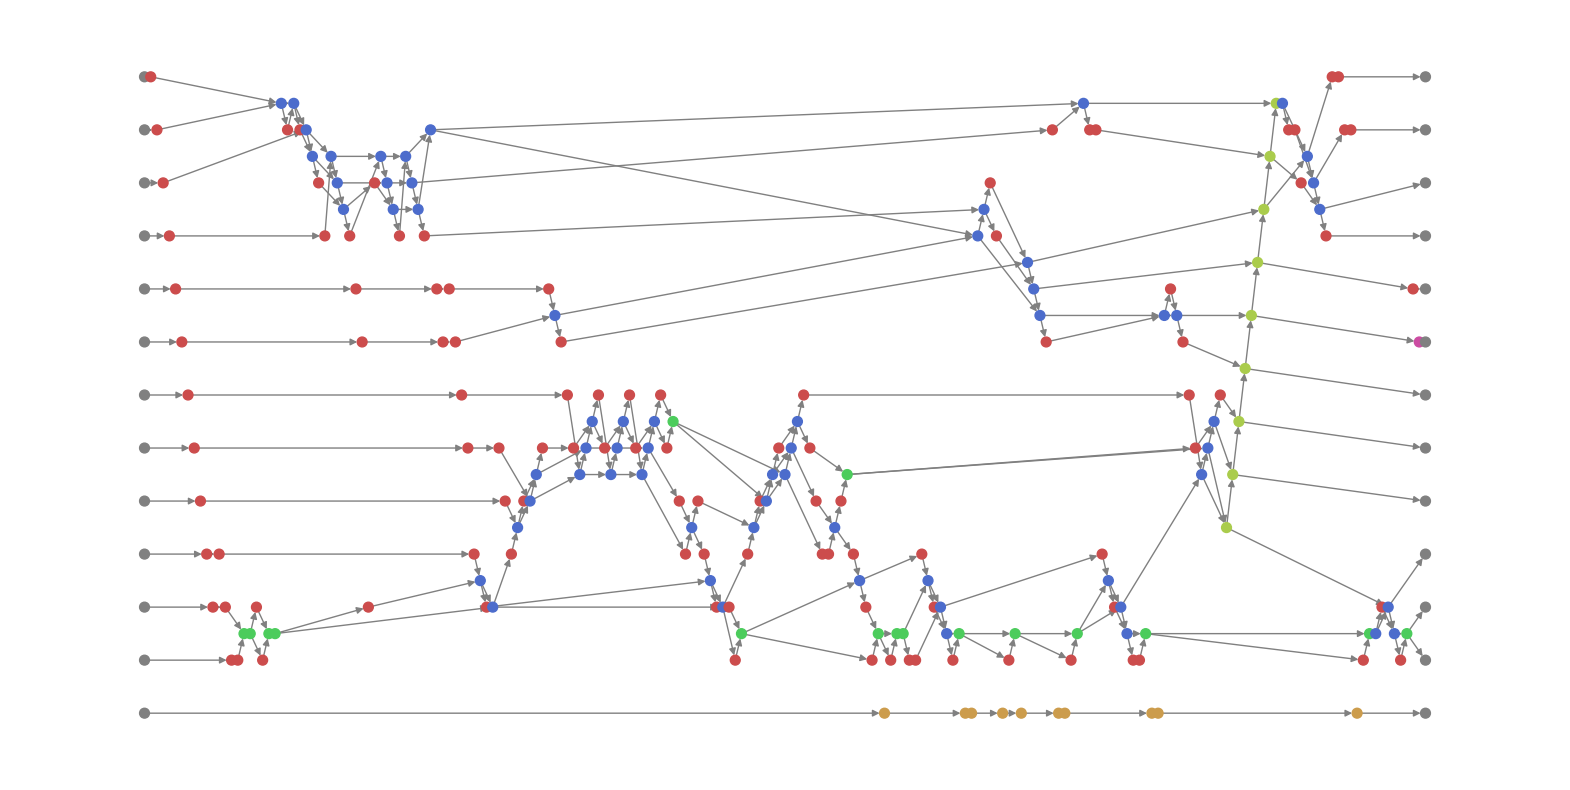

In [78]:
G, pos, node_colors = circuit_to_graph(circuit_info)
fig, ax = plt.subplots(figsize=(20, 10))
nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=50, font_size=10, edge_color='gray')
plt.show()

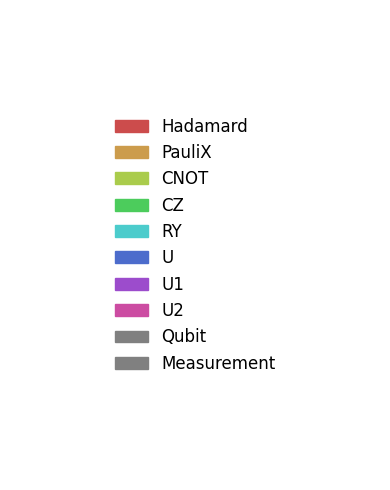

In [ ]:
gate_colors = {
    'Hadamard': '#cc4c4c',
    'PauliX': '#cc9c4c',
    'CNOT': '#aacc4c',
    'CZ': '#4ccc5c',
    'RY': '#4ccccc',
    'QubitUnitary': '#4c6ccc',
    'U1': '#9c4ccc',
    'U2': '#cc4ca2'
}

# Add qubit and measurement colors
extra_colors = {
    'Qubit': '#808080',
    'Measurement': "#808080"
}

# Combine all patches
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in {**gate_colors, **extra_colors}.items()]

# Create a standalone legend figure
fig, ax = plt.subplots(figsize=(4, len(legend_patches) * 0.5))
ax.axis('off')
legend = ax.legend(handles=legend_patches, loc='center', fontsize=12, frameon=False)
plt.tight_layout()
plt.show()

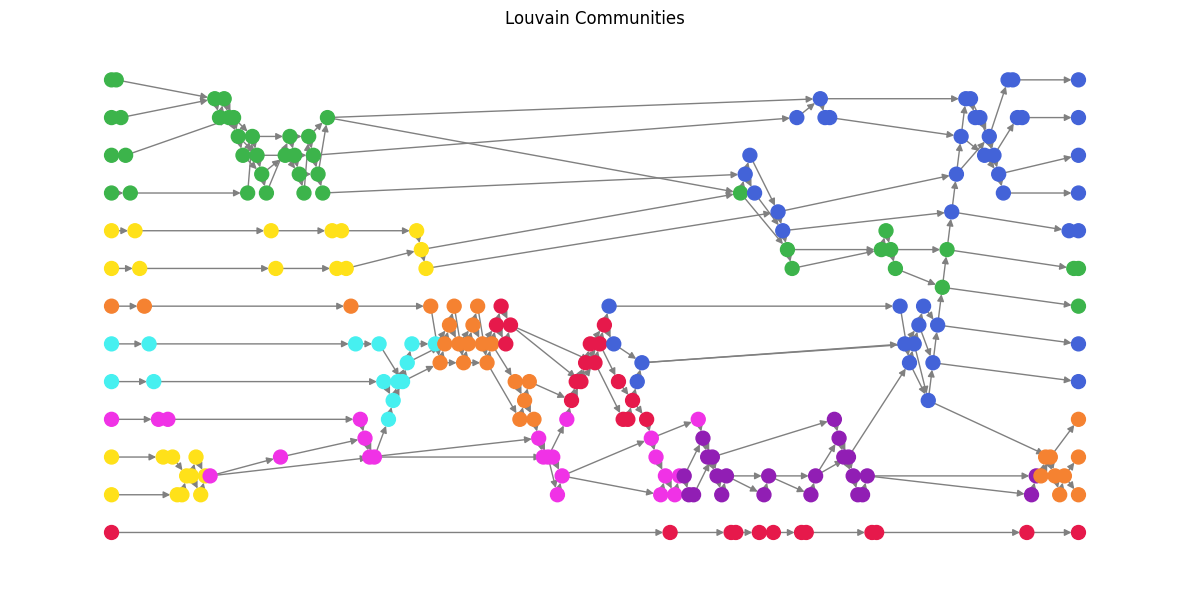

In [70]:
import community as community_louvain  # this is the python-louvain package

# Step 1: Apply Louvain method
partition = community_louvain.best_partition(G.to_undirected())

# Step 2: Assign colors to communities
palette = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6']
node_colors = [palette[partition[node] % len(palette)] for node in G.nodes]

# Step 3: Draw the graph
fig, ax = plt.subplots(figsize=(12, 6))
nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=100, font_size=8, edge_color='gray', ax=ax)
plt.title("Louvain Communities")
plt.tight_layout()
plt.show()

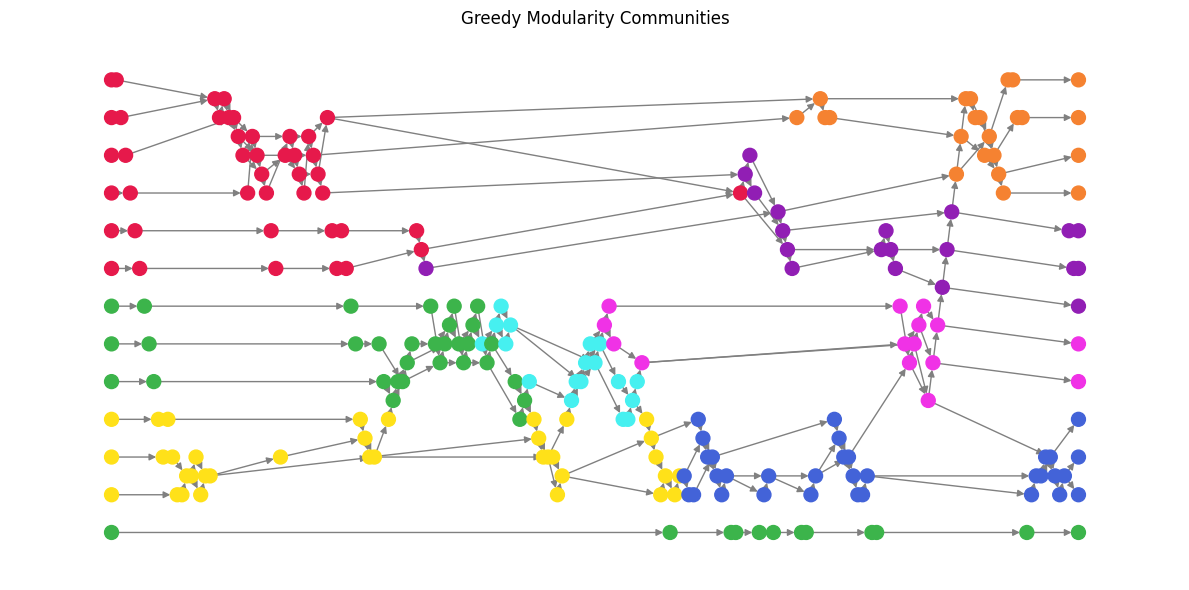

In [71]:
# Step 1: Apply Greedy Modularity
communities = list(nx.community.greedy_modularity_communities(G.to_undirected()))

# Step 2: Assign colors to communities
palette = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6']
node_color_map = {}
for i, community in enumerate(communities):
    color = palette[i % len(palette)]
    for node in community:
        node_color_map[node] = color

# Step 3: Build node_colors list
node_colors = [node_color_map.get(node, '#999999') for node in G.nodes]

# Step 4: Draw the graph
fig, ax = plt.subplots(figsize=(12, 6))
nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=100, font_size=8, edge_color='gray', ax=ax)
plt.title("Greedy Modularity Communities")
plt.tight_layout()
plt.show()

In [91]:
# Step 1: Apply Greedy Modularity
communities = list(nx.community.greedy_modularity_communities(G.to_undirected()))
print(len(communities))

# Step 2: Assign community index to each node in G
for i, community in enumerate(communities):
    for node in community:
        G.nodes[node]['community'] = i

12


In [90]:
[n for n in G.nodes if G.nodes[n].get('community') == 2]

['q[9]',
 'Hadamard_9',
 'Hadamard_11',
 'CZ_20',
 'Hadamard_35',
 'Hadamard_52',
 'QubitUnitary_53',
 'Hadamard_54',
 'QubitUnitary_55',
 'Hadamard_58',
 'Hadamard_89',
 'QubitUnitary_90',
 'Hadamard_91',
 'QubitUnitary_92',
 'Hadamard_93',
 'Hadamard_94',
 'CZ_95',
 'Hadamard_96',
 'Hadamard_113',
 'QubitUnitary_114',
 'Hadamard_115',
 'Hadamard_116',
 'CZ_117',
 'Hadamard_119',
 'CZ_120']

In [24]:
# compile
transpiled_circuit = compile(circuit)
print(summary_penny(transpiled_circuit))

fig, axs = qml.draw_mpl(transpiled_circuit, style='pennylane')()
fig.savefig('example_transpiled_circuit.png')
plt.show()

   num_qubit  num_gate  num_1q_gate  num_2q_gate  depth
0         11       795          319          476    378
None


In [21]:
fidelity_penny(circuit(), transpiled_circuit())

0.9999999999998743

In [83]:
dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev)
def simple_circuit():
    x = np.pi / 4
    y = np.pi / 3
    z = np.pi / 2
    qml.RX(x, wires=0)
    qml.RX(y, wires=0)
    qml.CNOT(wires=[1, 2])
    qml.RY(y, wires=1)
    qml.Hadamard(wires=2)
    qml.CRZ(z, wires=[2, 0])
    qml.RY(-y, wires=1)
    return qml.state()

qml.draw_mpl(circuit, style='pennylane')()
plt.show()

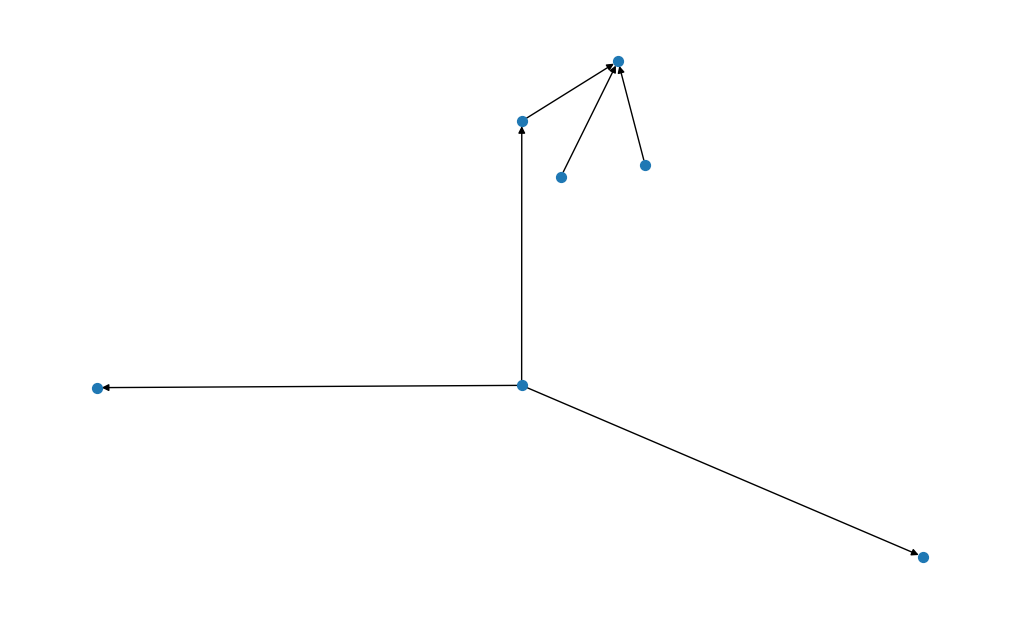

In [84]:
dag_fn = commutation_dag(simple_circuit)
dag = dag_fn()
G = dag.graph
plt.figure(figsize=(10, 6))
nx.draw(G, node_size=50, arrows=True) # pos,  
plt.show()

In [85]:
extract_info_from_qnode(simple_circuit)

[{'name': 'RX', 'wires': [0], 'params': [0.7853981633974483]},
 {'name': 'RX', 'wires': [0], 'params': [1.0471975511965976]},
 {'name': 'CNOT', 'wires': [1, 2], 'params': []},
 {'name': 'RY', 'wires': [1], 'params': [1.0471975511965976]},
 {'name': 'Hadamard', 'wires': [2], 'params': []},
 {'name': 'CRZ', 'wires': [2, 0], 'params': [1.5707963267948966]},
 {'name': 'RY', 'wires': [1], 'params': [-1.0471975511965976]}]

In [94]:
circuit_info = extract_info_from_qnode(circuit)
for dict_elem in circuit_info:
    if dict_elem['name'] in ['Hadamard', 'PauliX', 'RY', 'U1']:
        dict_elem['num_q'] = 1
    elif dict_elem['name'] in ['CNOT', 'CZ', 'U2']:
        dict_elem['num_q'] = 2
    elif dict_elem['name'] == 'QubitUnitary':
        dict_elem['num_q'] = len(dict_elem['params'][0])
    else:
        dict_elem['num_q'] = 0

In [99]:
circuit_info[10:15]

[{'name': 'CZ', 'wires': [8, 9], 'params': [], 'num_q': 2},
 {'name': 'Hadamard', 'wires': [9], 'params': [], 'num_q': 1},
 {'name': 'Hadamard', 'wires': [9], 'params': [], 'num_q': 1},
 {'name': 'CZ', 'wires': [8, 9], 'params': [], 'num_q': 2},
 {'name': 'CZ', 'wires': [8, 9], 'params': [], 'num_q': 2}]